# Importazione librerie

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Lettura dati Bitcoin

In [10]:
dati = pd.read_csv('Bitcoin (€) da yfinance dal 17-09-2014 al 24-04-2024.csv')
dati = dati[['Date', 'Close']]
dati = dati.rename(columns = {'Date':'Timestamp', 'Close': 'Price'})
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'])
dati['Timestamp'] = dati['Timestamp'].dt.strftime('%Y-%m-%d')
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'], format='%Y-%m-%d')
dati

,Timestamp,Price
0,2014-09-17,355.957367
1,2014-09-18,328.539368
2,2014-09-19,307.761139
3,2014-09-20,318.758972
4,2014-09-21,310.632446
...,...,...
3503,2024-04-20,59876.710938
3504,2024-04-21,60956.074219
3505,2024-04-22,60919.242188
3506,2024-04-23,62729.296875


In [11]:
# Bull market
# data_inizio = '2020-12-01'
# data_fine = '2021-04-30'

# Mercato laterale
# data_inizio = '2022-07-01'
# data_fine = '2022-10-31'

# Bear market
data_inizio = '2021-05-01'
data_fine = '2021-07-31'

# Periodo personale
# data_inizio = '2020-02-29'
# data_fine = '2021-12-01'

indice_inizio = dati[dati['Timestamp'] == data_inizio].index[0]
indice_fine = dati[dati['Timestamp'] == data_fine].index[0]
dati = dati[indice_inizio:indice_fine + 1].reset_index(drop=True)
dati

,Timestamp,Price
0,2021-05-01,48110.046875
1,2021-05-02,47088.570312
2,2021-05-03,47432.769531
3,2021-05-04,44387.261719
4,2021-05-05,47823.058594
...,...,...
87,2021-07-27,33336.066406
88,2021-07-28,33764.222656
89,2021-07-29,33643.082031
90,2021-07-30,35590.078125


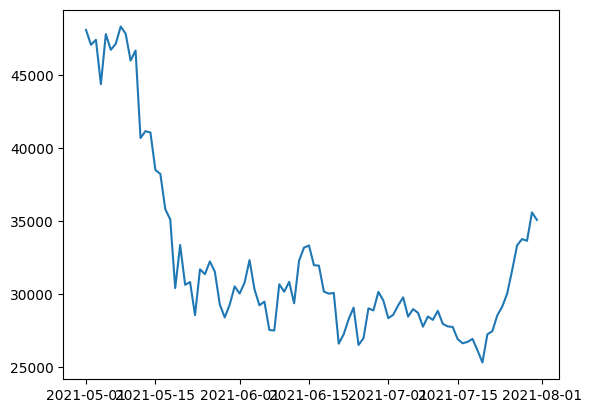

In [12]:
plt.plot(dati['Timestamp'], dati['Price'])

# Strategia

In [102]:
# Funzione helper per calcolare quanto acquistare
def quanto_acquistare(A_a, B_a, variazione_perc, liquidità_attuale, max_liquidità, spesa_primo_acquisto):
    return min(
        spesa_primo_acquisto + max_liquidità * abs(variazione_perc) ** A_a / (B_a + (1 - B_a) * abs(variazione_perc) ** A_a),
        liquidità_attuale
    )

# Funzione helper per calcolare quanto vendere
def quanto_vendere(A_v, B_v, variazione_vendite_inversa, bitcoin, max_bitcoin, bitcoin_venduti_prima_vendita):
    return min(
        bitcoin_venduti_prima_vendita + max_bitcoin * abs(variazione_vendite_inversa) ** A_v / (B_v + (1 - B_v) * abs(variazione_vendite_inversa) ** A_v),
        bitcoin
    )

# Funzione per calcolare la variazione percentuale per gli acquisti
def calcola_variazione_percentuale(prezzo_attuale, prezzo_riferimento):
    return (prezzo_attuale - prezzo_riferimento) / prezzo_riferimento

# Funzione per calcolare la variazione percentuale inversa per le vendite
def calcola_variazione_percentuale_inversa(prezzo_prima_vendita, prezzo_attuale):
    return (prezzo_prima_vendita - prezzo_attuale) / prezzo_attuale

# Funzione principale della strategia
def trading_semplificato(dati, min_acquisto, min_vendita, perc_commissione_acquisto, perc_commissione_vendita, 
                      liquidità_iniziale, bitcoin_iniziali, perc_primo_acquisto, perc_prima_vendita, 
                      A_a, B_a, A_v, B_v, compra_solo_sotto_ultimo):
    # Stato iniziale
    liquidità = liquidità_iniziale
    bitcoin = bitcoin_iniziali
    prezzo_medio_pesato_acquisti = None
    prezzo_medio_pesato_vendite = None
    spesa_totale_acquisti = 0
    guadagno_totale_vendite_euro = 0
    max_liquidità = liquidità
    max_bitcoin = bitcoin
    prezzo_prima_vendita = None
    prezzo_primo_acquisto = None
    prezzo_ultimo_acquisto = None
    transazioni = []  # Registro delle transazioni

    # Flag per identificare l'inizio di un nuovo ciclo
    nuovo_ciclo = True

    for i, row in dati.iterrows():
        timestamp = row['Timestamp']
        prezzo = row['Price']
        azione = '-'  # azione di default

        # Reset ciclo se necessario
        if i > 0 and prezzo < dati.iloc[i - 1]['Price'] and prezzo_prima_vendita is not None or i==0:
            nuovo_ciclo = True
            prezzo_medio_pesato_acquisti = None
            prezzo_medio_pesato_vendite = None
            prezzo_prima_vendita = None
            spesa_totale_acquisti = 0
            guadagno_totale_vendite_euro = 0
            max_liquidità = liquidità
            max_bitcoin = bitcoin
        else:
            nuovo_ciclo = False

        # Primo acquisto di un ciclo
        if nuovo_ciclo:
            spesa = liquidità * perc_primo_acquisto
            if spesa > 0 and spesa >= min_acquisto:
                commissione = spesa * perc_commissione_acquisto / prezzo  # Commissione in bitcoin
                bitcoin_acquistati = spesa / prezzo - commissione
                liquidità -= spesa
                bitcoin += bitcoin_acquistati
                prezzo_primo_acquisto = prezzo
                prezzo_ultimo_acquisto = prezzo
                prezzo_medio_pesato_acquisti = prezzo
                spesa_totale_acquisti = spesa
                max_liquidità = max(max_liquidità, liquidità)
                max_bitcoin = max(max_bitcoin, bitcoin)
                spesa_primo_acquisto = spesa
                azione = 'Primo acquisto'
            transazioni.append([
                timestamp, prezzo, azione, bitcoin_acquistati, spesa, liquidità, bitcoin, max_liquidità, max_bitcoin,
                prezzo_medio_pesato_acquisti, prezzo_medio_pesato_vendite, bitcoin*prezzo+liquidità
            ])
            continue
        # Calcola variazione percentuale rispetto al primo acquisto del ciclo
        variazione_perc = calcola_variazione_percentuale(prezzo, prezzo_primo_acquisto)

        # Scenario 1: prezzo < prezzo medio pesato di acquisto
        if prezzo <= prezzo_medio_pesato_acquisti:
            if (compra_solo_sotto_ultimo and prezzo < prezzo_ultimo_acquisto) or not compra_solo_sotto_ultimo:
                spesa = quanto_acquistare(A_a, B_a, variazione_perc, liquidità, max_liquidità, spesa_primo_acquisto)
                if spesa > 0 and spesa >= min_acquisto:
                    commissione = spesa * perc_commissione_acquisto / prezzo  # Commissione in bitcoin
                    bitcoin_acquistati = spesa / prezzo - commissione
                    liquidità -= spesa
                    bitcoin += bitcoin_acquistati
                    spesa_totale_acquisti += spesa
                    prezzo_medio_pesato_acquisti = (
                        (prezzo_medio_pesato_acquisti * (spesa_totale_acquisti - spesa) + prezzo * spesa) /
                        spesa_totale_acquisti
                    )
                    prezzo_ultimo_acquisto = prezzo
                    azione = 'Acquisto'

        # Scenario 2: prezzo > prezzo medio pesato di acquisto
        elif prezzo > prezzo_medio_pesato_acquisti:
            if prezzo_medio_pesato_vendite is None:  # Prima vendita del ciclo
                vendita = bitcoin * perc_prima_vendita
                if vendita > 0 and vendita >= min_vendita/prezzo:
                    vendita_euro = vendita * prezzo
                    commissione = vendita_euro * perc_commissione_vendita  # Commissione in euro
                    guadagno = vendita_euro - commissione
                    liquidità += guadagno
                    bitcoin -= vendita
                    prezzo_prima_vendita = prezzo
                    prezzo_medio_pesato_vendite = prezzo
                    guadagno_totale_vendite_euro = guadagno
                    bitcoin_venduti_prima_vendita = vendita
                    azione = 'Vendita'
            else:
                variazione_vendite_inversa = calcola_variazione_percentuale_inversa(prezzo_prima_vendita, prezzo)
                vendita = quanto_vendere(A_v, B_v, variazione_vendite_inversa, bitcoin, max_bitcoin, bitcoin_venduti_prima_vendita)
                if vendita > 0 and vendita >= min_vendita/prezzo:
                    vendita_euro = vendita * prezzo
                    commissione = vendita_euro * perc_commissione_vendita  # Commissione in euro
                    guadagno = vendita_euro - commissione
                    liquidità += guadagno
                    bitcoin -= vendita
                    prezzo_medio_pesato_vendite = (
                        (prezzo_medio_pesato_vendite * (guadagno_totale_vendite_euro - vendita_euro) + prezzo * vendita_euro) /
                        guadagno_totale_vendite_euro
                    )
                    guadagno_totale_vendite_euro += guadagno
                    azione = 'Vendita'

        # Aggiorna stato massimo
        max_liquidità = max(max_liquidità, liquidità)
        max_bitcoin = max(max_bitcoin, bitcoin)
        bitcoin_comprati_o_venduti = bitcoin_acquistati if azione=='Acquisto' else vendita if azione=='Vendita' else 0
        liquidità_spesa_o_guadagnata = spesa if azione=='Acquisto' else guadagno if azione=='Vendita' else 0

        # Registra l'azione del giorno
        transazioni.append([
            timestamp, prezzo, azione, bitcoin_comprati_o_venduti, liquidità_spesa_o_guadagnata, liquidità, bitcoin, max_liquidità, max_bitcoin,
            prezzo_medio_pesato_acquisti, prezzo_medio_pesato_vendite, bitcoin*prezzo+liquidità
        ])

    # Ritorna il dataframe delle transazioni
    return pd.DataFrame(transazioni, columns=[
        'timestamp', 'prezzo', 'azione', 'bitcoin_comprati_o_venduti', 'liquidità_spesa_o_guadagnata', 'liquidità', 'bitcoin', 
        'Max liquidità', 'Max bitcoin', 'prezzo Medio Pesato Acquisto', 'prezzo Medio Pesato Vendita', 'valore_totale_portafoglio'
    ])

In [103]:
min_acquisto = 5
min_vendita = 5
perc_commissione_acquisto = 0.001
perc_commissione_vendita = 0.001
liquidità_iniziale = 1000
bitcoin_iniziali = 0
perc_primo_acquisto = 0.01
perc_prima_vendita = 1
A_a = 0.5
B_a = 10
A_v = 0.2
B_v = 10
compra_solo_sotto_ultimo = True

df_transazioni = trading_semplificato(dati, min_acquisto, min_vendita, perc_commissione_acquisto, perc_commissione_vendita, liquidità_iniziale, bitcoin_iniziali, perc_primo_acquisto, perc_prima_vendita, A_a, B_a, A_v, B_v, compra_solo_sotto_ultimo)
df_transazioni

,timestamp,prezzo,azione,bitcoin_comprati_o_venduti,liquidità_spesa_o_guadagnata,liquidità,bitcoin,Max liquidità,Max bitcoin,prezzo Medio Pesato Acquisto,prezzo Medio Pesato Vendita,valore_totale_portafoglio
0,2021-05-01,48110.046875,Primo acquisto,0.000208,10.000000,990.000000,0.000208,1000.000000,0.000208,48110.046875,NaN,999.990000
1,2021-05-02,47088.570312,Acquisto,0.000568,26.770540,963.229460,0.000776,1000.000000,0.000776,47366.367851,NaN,999.751121
2,2021-05-03,47432.769531,Vendita,0.000776,36.751832,999.981292,0.000000,1000.000000,0.000776,47366.367851,47432.769531,999.981292
3,2021-05-04,44387.261719,Primo acquisto,0.000225,9.999813,989.981479,0.000225,999.981292,0.000225,44387.261719,NaN,999.971292
4,2021-05-05,47823.058594,Vendita,0.000225,10.752312,1000.733790,0.000000,1000.733790,0.000225,44387.261719,47823.058594,1000.733790
...,...,...,...,...,...,...,...,...,...,...,...,...
87,2021-07-27,33336.066406,-,0.000000,0.000000,1036.566439,0.000000,1036.566439,0.008330,26505.488291,27227.458984,1036.566439
88,2021-07-28,33764.222656,-,0.000000,0.000000,1036.566439,0.000000,1036.566439,0.008330,26505.488291,27227.458984,1036.566439
89,2021-07-29,33643.082031,Primo acquisto,0.000308,10.365664,1026.200774,0.000308,1036.566439,0.000308,33643.082031,NaN,1036.556073
90,2021-07-30,35590.078125,Vendita,0.000308,10.943627,1037.144401,0.000000,1037.144401,0.000308,33643.082031,35590.078125,1037.144401


In [104]:
df_transazioni[df_transazioni['azione'] == 'Primo acquisto']

,timestamp,prezzo,azione,bitcoin_comprati_o_venduti,liquidità_spesa_o_guadagnata,liquidità,bitcoin,Max liquidità,Max bitcoin,prezzo Medio Pesato Acquisto,prezzo Medio Pesato Vendita,valore_totale_portafoglio
0,2021-05-01,48110.046875,Primo acquisto,0.000208,10.000000,990.000000,0.000208,1000.000000,0.000208,48110.046875,NaN,999.990000
3,2021-05-04,44387.261719,Primo acquisto,0.000225,9.999813,989.981479,0.000225,999.981292,0.000225,44387.261719,NaN,999.971292
5,2021-05-06,46742.558594,Primo acquisto,0.000214,10.007338,990.726452,0.000214,1000.733790,0.000214,46742.558594,NaN,1000.723783
8,2021-05-09,47846.523438,Primo acquisto,0.000209,10.008020,990.793999,0.000209,1000.802019,0.000209,47846.523438,NaN,1000.792011
11,2021-05-12,40695.511719,Primo acquisto,0.000246,10.009737,990.963969,0.000246,1000.973706,0.000246,40695.511719,NaN,1000.963697
13,2021-05-14,41072.777344,Primo acquisto,0.000243,10.010694,991.058667,0.000243,1001.069361,0.000243,41072.777344,NaN,1001.059350
34,2021-06-04,30322.699219,Primo acquisto,0.000333,10.117951,1001.677174,0.000333,1011.795125,0.000333,30322.699219,NaN,1011.785007
40,2021-06-10,30150.488281,Primo acquisto,0.000340,10.252759,1015.023168,0.000340,1025.275927,0.000340,30150.488281,NaN,1025.265674
42,2021-06-12,29360.513672,Primo acquisto,0.000349,10.254867,1015.231870,0.000349,1025.486737,0.000349,29360.513672,NaN,1025.476482
46,2021-06-16,31969.333984,Primo acquisto,0.000321,10.264862,1016.221307,0.000321,1026.486168,0.000321,31969.333984,NaN,1026.475903


In [105]:
df_transazioni['valore_totale_portafoglio'].iloc[-1] / df_transazioni['valore_totale_portafoglio'].iloc[0]

np.float64(1.0371444012360358)

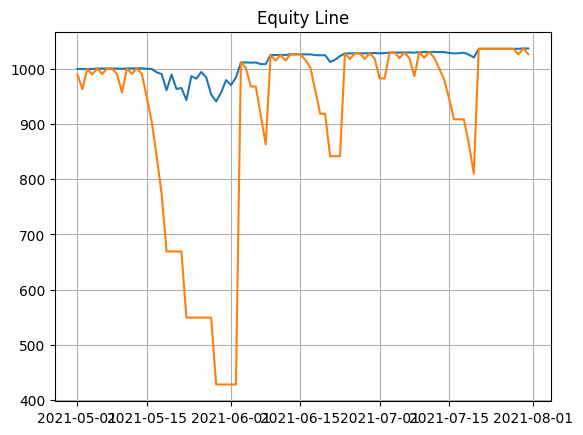

In [106]:
plt.title('Equity Line')
plt.grid()
plt.plot(df_transazioni['timestamp'], df_transazioni['valore_totale_portafoglio'])
plt.plot(df_transazioni['timestamp'], df_transazioni['liquidità'])

In [107]:
# Funzione per creare il grafico delle transazioni
def crea_grafico_transazioni(df_transazioni):
    # Gestione NaN per sicurezza
    df_transazioni['bitcoin_comprati_o_venduti'] = pd.to_numeric(df_transazioni['bitcoin_comprati_o_venduti'], errors='coerce')
    df_transazioni['liquidità_spesa_o_guadagnata'] = pd.to_numeric(df_transazioni['liquidità_spesa_o_guadagnata'], errors='coerce')

    # Filtra solo le transazioni di vendita e acquisto
    vendite = df_transazioni[df_transazioni['azione'] == 'Vendita']
    acquisti = df_transazioni[(df_transazioni['azione'] == 'Acquisto') | (df_transazioni['azione'] == 'Primo acquisto')]

    # Calcolo della dimensione dei punti per le vendite e gli acquisti
    max_quantita_vendita = vendite['bitcoin_comprati_o_venduti'].abs().max()
    max_quantita_acquisto = acquisti['liquidità_spesa_o_guadagnata'].max()

    def calcola_dimensione(quantita, max_quantita, min_size=10, max_size=50):
        return min_size + (max_size - min_size) * (quantita / max_quantita) if max_quantita != 0 else min_size

    # Applica la funzione di dimensione per ogni punto vendita e acquisto
    dimensioni_vendite = vendite['bitcoin_comprati_o_venduti'].abs().apply(lambda x: calcola_dimensione(x, max_quantita_vendita))
    dimensioni_acquisti = acquisti['liquidità_spesa_o_guadagnata'].apply(lambda x: calcola_dimensione(x, max_quantita_acquisto))

    # Funzione per creare una stringa di hover con tutte le colonne
    def crea_hover_text(df):
        hover_texts = []
        for _, row in df.iterrows():
            hover_text = "<br>".join([f"{col}: {row[col]}" for col in df.columns])
            hover_texts.append(hover_text)
        return hover_texts

    # Creazione del grafico
    fig = go.Figure()

    # Linea dell'andamento dei prezzi
    fig.add_trace(go.Scatter(
        x=df_transazioni['timestamp'],
        y=df_transazioni['prezzo'],
        mode='lines',
        name='Prezzi Bitcoin',
        line=dict(color='blue', width=2),
        hoverinfo='x+y'
    ))

    # Scatter plot per le vendite
    fig.add_trace(go.Scatter(
        x=vendite['timestamp'],
        y=vendite['prezzo'],
        mode='markers',
        name='Vendite',
        marker=dict(color='red', size=dimensioni_vendite, opacity=0.7),
        text=crea_hover_text(vendite),
        hoverinfo='text'
    ))

    # Scatter plot per gli acquisti
    fig.add_trace(go.Scatter(
        x=acquisti['timestamp'],
        y=acquisti['prezzo'],
        mode='markers',
        name='Acquisti',
        marker=dict(color='green', size=dimensioni_acquisti, opacity=0.7),
        text=crea_hover_text(acquisti),
        hoverinfo='text'
    ))

    # Configurazione del layout
    fig.update_layout(
        title='Andamento Prezzi Bitcoin, Transazioni di Vendita e Acquisto',
        xaxis_title='Data',
        yaxis_title='Prezzo (€)',
        hovermode='closest',
        template='plotly_white',
        legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
        width=1200,
        height=800,
        xaxis=dict(
            rangeslider=dict(visible=True),  # Abilita il range slider
            type="date"  # Imposta l'asse x come asse temporale
        )
    )

    # Mostra il grafico
    fig.show()

In [108]:
crea_grafico_transazioni(df_transazioni)